In [1]:
# load libraries
import xarray as xr
from minisom import MiniSom
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
import numpy as np

from hyperopt import fmin, tpe, hp, Trials  , STATUS_OK


# SOM Spatio-Temporal Example -- Parameters tunning

## Open and Explore data

Air temperature data from the US

In [2]:
# open xarray tutorial dataset
ds = xr.tutorial.open_dataset("air_temperature.nc").rename({"air": "Tair"})
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


In [3]:
print(ds.description)

Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.


(array([   2182.,   60537.,  195026.,  233763.,  315219.,  635948.,
         778807., 1192236.,  453381.,    1901.]),
 array([221.     , 230.64   , 240.28   , 249.92   , 259.56   , 269.2    ,
        278.84   , 288.47998, 298.12   , 307.76   , 317.4    ],
       dtype=float32),
 <a list of 10 Patch objects>)

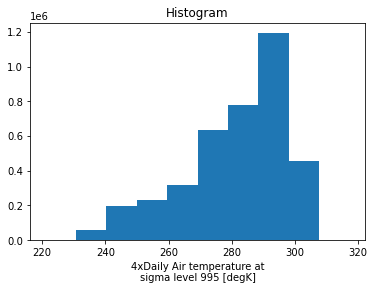

In [4]:
# plot histogram
ds.Tair.plot()

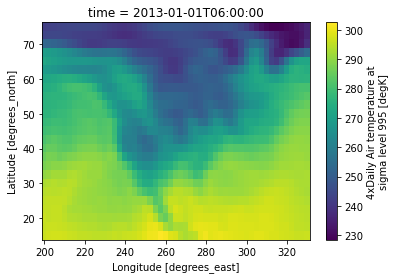

In [5]:
# plot at initial time
ds.Tair.isel(time=1).plot()

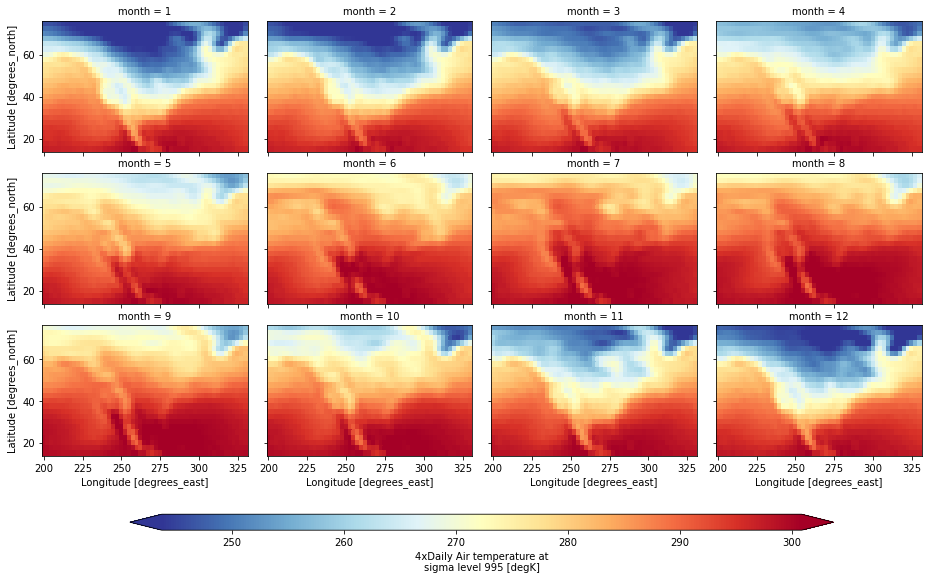

In [6]:
# group by month and plot it:
monthly_means = ds.groupby("time.month").mean()
# xarray's groupby reductions drop attributes. Let's assign them back so we get nice labels.
monthly_means.Tair.attrs = ds.Tair.attrs

fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,  # each row has a maximum of 4 columns
        # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)


# SOM Parameters Optmization

A way to find the ideal sigma and learning rate, is by searching the values that will give us the smaller Quantification Error (QE), given a neighborhood function and neural map size. 

We can use the python package **hyperopt** for this.

Read more [here](https://towardsdatascience.com/algorithms-for-hyperparameter-optimisation-in-python-edda4bdb167)

In [7]:
# define SOM parameters
som_map = (3,3) # we will try a 3x3 neural map
x,y=som_map
sigma = 1 # default value
learning_rate = 0.5 # default value
ngb_function = 'gaussian' # choosing between ['gaussian' ,'bubble','mexican_hat']
init = 'pca' # we will initialize SOM randomly. Option: 'pca'
train = 'batch' # perform batch traning instead of random (default)
iterations = 10000 # lenght of training
topology = 'rectangular' # to ensure equidistant ditance neighbors
topology='hexagonal'
activation_distance = 'euclidean'

In [8]:
# data params
data_in=np.array(ds['Tair'])
dimlon=len(ds['lon'])
dimlat= len(ds['lat'])
dimtime = len(ds['time'])

In [9]:
# use simple SOM as example
data = np.nanmean(data_in,axis=0)
# normalize data
data = (data - np.nanmean(data, axis=0)) / np.nanstd(data, axis=0)
X=np.array(data)
input_len=X.shape[1]
init='pca'
# create som
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)

starting_weights = som.get_weights()

# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)
    
qnt1 = som.quantization(X)
weights1 = som.get_weights()

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [  1690 / 10000 ]  17% - 0:00:01 left 

 [  2853 / 10000 ]  29% - 0:00:00 left 

 [  4054 / 10000 ]  41% - 0:00:00 left 

 [  5598 / 10000 ]  56% - 0:00:00 left 

 [  6850 / 10000 ]  68% - 0:00:00 left 

 [  8288 / 10000 ]  83% - 0:00:00 left 

 [  9699 / 10000 ]  97% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9535273382870869


In [10]:
from hyperopt import fmin, tpe, hp, Trials  , STATUS_OK

### Define the search space
space = {
    # hp.choice.choice will select 1 value from the given list
    # hp.hp.quniform returns a float between a given range
    'sigma':hp.quniform('sigma',0.0,1.0,0.05),
    #  'sigma':hp.choice('sigma', np.arange(0.1, 3,0.5, dtype=float)),
    'learning_rate':hp.quniform('learning_rate',0.1,1,0.05),

}


### define the objective function
def som_fn(space):

        sigma = space['sigma']
        learning_rate =  space['learning_rate']
        som = MiniSom(x, y, input_len, 
              sigma=sigma,
              learning_rate=learning_rate, 
              neighborhood_function=ngb_function,
              topology=topology,
              activation_distance=activation_distance,
              random_seed=None
                     )
        
        # initialize SOM
        som.pca_weights_init(X)
        # train SOM
        som.train_batch(X, iterations, verbose=False)
        
        # remember to use the same parameters as you are using out of the tuning function
        
        # use QE as a measure of best model
        loss = som.quantization_error(X)
        return {'loss': loss, 'status': STATUS_OK}
    
### Storing the results of every iteration    
trials = Trials()
MAX_EVALS = 20

# Optimize
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=MAX_EVALS,
           trials=trials)


### best will the return the the best hyperparameter set
print('best: {}'.format(best))



 25%|██▌       | 5/20 [00:03<00:09,  1.63trial/s, best loss: 0.8420693218652582]

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/minisom.py:249: RuntimeWarning: divide by zero encountered in true_divide
  ax = exp(-power(self._xx-self._xx.T[c], 2)/d)

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/minisom.py:249: RuntimeWarning: invalid value encountered in true_divide
  ax = exp(-power(self._xx-self._xx.T[c], 2)/d)

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/minisom.py:250: RuntimeWarning: divide by zero encountered in true_divide
  ay = exp(-power(self._yy-self._yy.T[c], 2)/d)

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/minisom.py:250: RuntimeWarning: invalid value encountered in true_divide
  ay = exp(-power(self._yy-self._yy.T[c], 2)/d)



 90%|█████████ | 18/20 [00:09<00:01,  1.95trial/s, best loss: 0.8420693218652582]

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/minisom.py:486: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



100%|██████████| 20/20 [00:10<00:00,  1.83trial/s, best loss: 0.8420693218652582]
best: {'learning_rate': 0.5, 'sigma': 0.5}


In [11]:
# run SOM with updated parameters
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=best['sigma'],learning_rate=best['learning_rate'],
#                                  sigma=0.15,
                    #learning_rate=0.5,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)

# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)
    
qnt2 = som.quantization(X)
weights2 = som.get_weights()

 [  1676 / 10000 ]  17% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8420693218652582


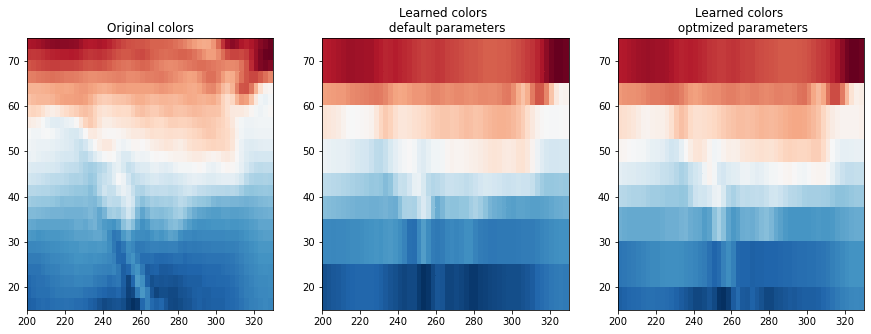

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('original')
plt.pcolor(ds.lon,ds.lat,X,
          cmap='RdBu',)
plt.title('Original colors')
plt.subplot(132)
plt.pcolor(ds.lon,ds.lat,qnt1,
          cmap='RdBu',)
plt.title('Learned colors \n default parameters')

plt.subplot(133)
plt.pcolor(ds.lon,ds.lat,qnt2,
          cmap='RdBu',)
plt.title('Learned colors \n optmized parameters')
plt.show()

## Spatial clusters

In [13]:
data=np.array(data_in)
# we need to concatenate the dataset to 2D:
data=data_in.reshape(dimtime,dimlat*dimlon)

# normalize dataset:
data = (data - np.nanmean(data)) / np.nanstd(data)

np.std(data)

0.9999999

In [14]:
np.mean(data)

-5.6814283e-06

In [15]:
data=np.array(data_in)
# we need to concatenate the dataset to 2D:
data=data_in.reshape(dimtime,dimlat*dimlon)

# normalize dataset:
data = (data - np.nanmean(data, axis=0)) / np.nanstd(data, axis=0)
data = (data - np.nanmean(data)) / np.nanstd(data)

# to analyse in time domain we need to transpose it:
X = data.T
input_len=X.shape[1]

# create som
# default parameters
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)

starting_weights = som.get_weights()

# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)
weights1 = som.get_weights() 
# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

qnt1 = som.quantization(X)

# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index1 = np.ravel_multi_index(winner_coordinates, (x,y))



 [   527 / 10000 ]   5% - 0:00:03 left 

 [  1076 / 10000 ]  11% - 0:00:03 left 

 [  1655 / 10000 ]  17% - 0:00:03 left 

 [  2272 / 10000 ]  23% - 0:00:02 left 

 [  2918 / 10000 ]  29% - 0:00:02 left 

 [  3570 / 10000 ]  36% - 0:00:02 left 

 [  4218 / 10000 ]  42% - 0:00:01 left 

 [  4889 / 10000 ]  49% - 0:00:01 left 

 [  5581 / 10000 ]  56% - 0:00:01 left 

 [  6252 / 10000 ]  63% - 0:00:01 left 

 [  6925 / 10000 ]  69% - 0:00:00 left 

 [  7592 / 10000 ]  76% - 0:00:00 left 

 [  8255 / 10000 ]  83% - 0:00:00 left 

 [  8923 / 10000 ]  89% - 0:00:00 left 

 [  9594 / 10000 ]  96% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 


 quantization error: 29.114306671557408


In [16]:
### Define the search space
space = {
    # hp.choice.choice will select 1 value from the given list
    # hp.hp.quniform returns a float between a given range
    'sigma':hp.quniform('sigma',0.0,1.0,0.05),
    #  'sigma':hp.choice('sigma', np.arange(0.1, 3,0.5, dtype=float)),
    'learning_rate':hp.quniform('learning_rate',0.1,1,0.05),

}


### define the objective function
def som_fn(space):

        sigma = space['sigma']
        learning_rate =  space['learning_rate']
        som = MiniSom(x, y, input_len, 
                  sigma=sigma,
                  learning_rate=learning_rate, 
                  neighborhood_function=ngb_function,
                  topology=topology,
                  activation_distance=activation_distance,
                  random_seed=None
                     )
        
        # initialize SOM
        if init=='pca':
            som.pca_weights_init(X)
        else:
            som.random_weights_init(X)
        # train som
        if train=='random':
            som.train_random(X,iterations,verbose=False)
        else:
            som.train_batch(X,iterations,verbose=False)
        
        # remember to use the same parameters as you are using out of the tuning function
        
        # use QE as a measure of best model
        loss = som.quantization_error(X)
        return loss
    
### Storing the results of every iteration    
trials = Trials()
MAX_EVALS = 20

# Optimize
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=MAX_EVALS,
           trials=trials)


### best will the return the the best hyperparameter set
print('best: {}'.format(best))


100%|██████████| 20/20 [03:17<00:00,  9.90s/trial, best loss: 27.748766109556758]
best: {'learning_rate': 0.25, 'sigma': 0.9500000000000001}


In [17]:
# Run SOM with optmized values
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=best['sigma'],learning_rate=best['learning_rate'],
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)
weights2 = som.get_weights() 
# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

qnt2 = som.quantization(X)

# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index2 = np.ravel_multi_index(winner_coordinates, (x,y))



 [   530 / 10000 ]   5% - 0:00:03 left 

 [  1125 / 10000 ]  11% - 0:00:03 left 

 [  1725 / 10000 ]  17% - 0:00:02 left 

 [  2328 / 10000 ]  23% - 0:00:02 left 

 [  2936 / 10000 ]  29% - 0:00:02 left 

 [  3520 / 10000 ]  35% - 0:00:02 left 

 [  4103 / 10000 ]  41% - 0:00:02 left 

 [  4714 / 10000 ]  47% - 0:00:01 left 

 [  5320 / 10000 ]  53% - 0:00:01 left 

 [  5930 / 10000 ]  59% - 0:00:01 left 

 [  6567 / 10000 ]  66% - 0:00:01 left 

 [  7232 / 10000 ]  72% - 0:00:00 left 

 [  7890 / 10000 ]  79% - 0:00:00 left 

 [  8554 / 10000 ]  86% - 0:00:00 left 

 [  9226 / 10000 ]  92% - 0:00:00 left 

 [  9903 / 10000 ]  99% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 27.748766109556758


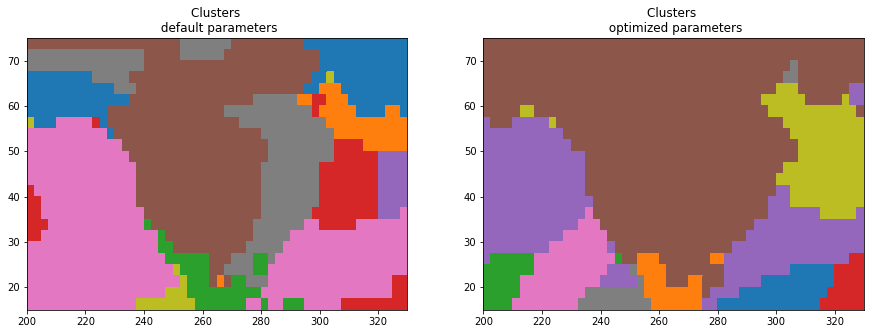

In [18]:
# plot clusters
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Clusters \n default parameters')
plt.pcolor(ds.lon,ds.lat,cluster_index1.reshape(dimlat,dimlon),
           vmin=0,vmax=x*y,cmap='tab10');

plt.subplot(122)
plt.title('Clusters \n optimized parameters')
plt.pcolor(ds.lon,ds.lat,cluster_index2.reshape(dimlat,dimlon),
           vmin=0,vmax=x*y,cmap='tab10');

plt.show()